
## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
import time
from math import sqrt,ceil
from pathlib import Path
import sys
import math
from numpy import genfromtxt

np.set_printoptions(threshold=sys.maxsize)

## Assemble Coefficient Matrix


In [2]:
def assemble_matrix(Nx,Ny,Lx,Ly,mu,rho,scaleFactor,v):
    
    dx = Lx/Nx
    dy = Ly/Ny
    M = int(Nx*Ny)
    
    #-----COEFFICIENTS----
    #X-MOM and Y_MOM
    #velocities
    ax = mu*dy/dx
    ay = mu*dx/dy

    ap = -2*(ax+ay)
    g = 9.81#gravity
    
    #CONTINUITY
    #velocities and pressure gradients momentum
    ex = dy/2
    ey = dx/2

    
    #smoothing term
    D = scaleFactor*dx*dy/(ap)

    #LHS Pressure Gradient
    Sx = (D*dy)/dx
    Sy = (D*dx)/dy
    Sp = -2*(Sx+Sy)

    
    eqs = 3 #3 equations (momentum x, y and continuity)
    
    #Initialise coefficient matrix
    A = np.zeros((eqs*M, eqs*M))
     #Initialise source vector
    b = np.zeros((eqs*M, 1))
   
    internal = (Nx-2)*(Ny-2)
    corners = 4
    horizontal_sides = (Nx-2)*2
    vertical_side = (Ny-2)
    numNonZeros = int(20*horizontal_sides+19*vertical_side+20*vertical_side+66+internal*23) #20 by inlet,bot,top, 
    #19 by outlet, 66 for corners, 23 for internal

    data = np.zeros((numNonZeros))
    row_idx = np.zeros((numNonZeros ))
    col_idx = np.zeros((numNonZeros ))
    
    #get indices of corner cells
    botright = eqs*(Nx-1)
    topleft = eqs*(Nx*(Ny-1))
    topright = eqs*(Nx*Ny-1)
    
    #Loop through each cell i

    coeffi=0
    for i in range(0, eqs*M, eqs):
        
        #CORNERS
        #bottom left
        if i == 0:
            #convection coeffs
            ge = -rho*dy*(v[i+3]+v[i])/4 #Ae(vex+vpx)/4
            gn = -rho*dx*(v[i+eqs*Nx+1]+v[i+1])/4 #An(vny+vpy)/4
            
            #X-MOM
            #-------#
            #RHS
            b[i] = -2*ax*vin[0]+dy*vin[0]**2*rho
            #LHS
            
            #vpx
            data[coeffi] = -3*ax-3*ay +ge+gn
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vex
            data[coeffi] = ax+ge 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            #vnx
            data[coeffi] = ay +gn
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            #Pe
            data[coeffi] = -ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            #Pp
            data[coeffi] = ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = -2*ax*vin[1]+dy*vin[0]*vin[1]*rho
            #LHS
            
            #vpy
            data[coeffi] = -3*ax-3*ay +ge+gn
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vey
            data[coeffi] = ax +ge 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vny
            data[coeffi] = ay +gn
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = ey  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #CONTINUITY
            #-------#
            #LHS
            
            #vpx
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pn
            data[coeffi] = Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = Sp/2  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
           
        #bottom right
        elif i == botright:
            
            gw = rho*dy*(v[i-3]+v[i])/4 #-Aw(vwx+vpx)/4
            gn = -rho*dx*(v[i+eqs*Nx+1]+v[i+1])/4 #An(vny+vpy)/4
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
            #vpx
            data[coeffi] = -ax-3*ay+gw+gn-dy*v[i]*rho 
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax+gw  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            #vnx
            data[coeffi] = ay+gn  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = (4/3)*ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1

            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = -ax-3*ay+gw+gn-dy*v[i]*rho 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax +gw 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            #vny
            data[coeffi] = ay +gn 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = ey  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #CONTINUITY
            #-------#
 
            #LHS
            
            #vpx
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
#             #Pw
#             data[coeffi] = Sx
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-1
            
#             coeffi+=1
            
#             #Pn
#             data[coeffi] = Sy  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+eqs*Nx+2
            
#             coeffi+=1
            
#             #Pp
#             data[coeffi] = -3*Sx-Sy  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+2
            
#             coeffi+=1
            
        #Top Left
        elif i == topleft:
            
            ge = -rho*dy*(v[i+3]+v[i])/4 #Ae(vex+vpx)/4
            gs = rho*dx*(v[i-eqs*Nx+1]+v[i+1])/4 #-As(vsy+vpy)/4
            #X-MOM
            #-------#
            #RHS
            b[i] = -2*ax*vin[0]+dy*rho*vin[0]**2
            #LHS
            
            #vpx
            data[coeffi] = -3*ax-3*ay+ge+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vex
            data[coeffi] = ax +ge 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            #vsx
            data[coeffi] = ay +gs 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pe
            data[coeffi] = -ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pp
            data[coeffi] = ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1

            #Y-MOM
            #-------#
            #RHS
            b[i+1] = -2*ax*vin[1]+dy*rho*vin[0]*vin[1]
            #LHS
            
            #vpy
            data[coeffi] = -3*ax-3*ay+ge+gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vey
            data[coeffi] = ax +ge
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vsy
            data[coeffi] = ay +gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = -ey  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
     
            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = -ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Ps
            data[coeffi] = Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = Sp/2  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
     
        #top right
        elif i == topright:
            
            gw = rho*dy*(v[i-3]+v[i])/4 #-Aw(vwx+vpx)/4
            gs = rho*dx*(v[i-eqs*Nx+1]+v[i+1])/4 #-As(vsy+vpy)/4
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
            #vpx
            data[coeffi] = -ax-3*ay-rho*dy*v[i]+gw+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax+gw
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            #vsx
            data[coeffi] = ay+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = (4/3)*ex
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
               
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = -ax-3*ay-rho*dy*v[i]+gw+gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax +gw 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            #vsy
            data[coeffi] = ay +gs 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = -ey  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1

            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = -ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
#             #Pw
#             data[coeffi] = Sx
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-1
            
#             coeffi+=1
            
#             #Ps
#             data[coeffi] = Sy  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-eqs*Nx+2
            
#             coeffi+=1
            
#             #Pp
#             data[coeffi] = -3*Sx-Sy  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+2
            
#             coeffi+=1
            
        #SIDES
        #bottom
        elif 0 < i < botright:
            
            ge = -rho*dy*(v[i+3]+v[i])/4 #Ae(vex+vpx)/4
            gw = rho*dy*(v[i-3]+v[i])/4 #-Aw(vwx+vpx)/4
            gn = -rho*dx*(v[i+eqs*Nx+1]+v[i+1])/4 #An(vny+vpy)/4
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            #vpx
            data[coeffi] = -2*ax-3*ay +ge+gw+gn
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax +gw
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ax +ge
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ay +gn 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = -ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            #vpy
            data[coeffi] = -2*ax-3*ay  +ge+gw+gn
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax +gw
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vey
            data[coeffi] = ax +ge
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vny
            data[coeffi] = ay +gn
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = ey  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
    
            #CONTINUITY
            #-------#

            #LHS
            
            #vpy
            data[coeffi] = ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #Pw
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pn
            data[coeffi] = Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = -2*Sx-Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
           
        #top
        elif topleft < i < topright:
            
            ge = -rho*dy*(v[i+3]+v[i])/4 #Ae(vex+vpx)/4
            gw = rho*dy*(v[i-3]+v[i])/4 #-Aw(vwx+vpx)/4
            gs = rho*dx*(v[i-eqs*Nx+1]+v[i+1])/4 #-As(vsy+vpy)/4
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
            #vpx
            data[coeffi] = -2*ax-3*ay+ge+gw+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax +gw
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ax +ge
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ay +gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = -ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = -2*ax-3*ay +ge+gw+gs 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax  +gw
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vey
            data[coeffi] = ax +ge
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vsy
            data[coeffi] = ay +gs 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = -ey  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1

            #CONTINUITY
            #-------#

            #LHS
            
            #vpy
            data[coeffi] = -ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #Pw
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Ps
            data[coeffi] = Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = -2*Sx-Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
        #left / Inlet
        elif i in range(eqs*Nx,topleft,eqs*Nx):
            
            ge = -rho*dy*(v[i+3]+v[i])/4 #Ae(vex+vpx)/4
            gn = -rho*dx*(v[i+eqs*Nx+1]+v[i+1])/4 #An(vny+vpy)/4
            gs = rho*dx*(v[i-eqs*Nx+1]+v[i+1])/4 #-As(vsy+vpy)/4
            #X-MOM
            #-------#
            #RHS
            b[i] = -2*ax*vin[0]+rho*dy*vin[0]**2
            #LHS
            
             #vpx
            data[coeffi] = -3*ax-2*ay+ge+gn+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vex
            data[coeffi] = ax +ge
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ay+gn
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ay + gs 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pe
            data[coeffi] = -ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pp
            data[coeffi] = ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = -2*ax*vin[1]+rho*dy*vin[0]*vin[1]
            #LHS
            #vpy
            data[coeffi] = -3*ax-2*ay +ge+gn+gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vey
            data[coeffi] = ax +ge
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            
            #vny
            data[coeffi] = ay +gn
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = ay +gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = ey  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pn
            data[coeffi] = -ey  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1

            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = ex  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pn
            data[coeffi] = Sy
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = -Sx-2*Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
    
        #right / Outlet
        elif i in range(botright+eqs*Nx,topright,eqs*Nx):
            
            gw = rho*dy*(v[i-3]+v[i])/4 #-Aw(vwx+vpx)/4
            gn = -rho*dx*(v[i+eqs*Nx+1]+v[i+1])/4 #An(vny+vpy)/4
            gs = rho*dx*(v[i-eqs*Nx+1]+v[i+1])/4 #-As(vsy+vpy)/4
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
             #vpx
            data[coeffi] = -ax-2*ay +gw+gn+gs-rho*dy*v[i] 
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax +gw
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ay +gn
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ay +gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = (4/3)*ex 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
    
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = -ax-2*ay+gw+gn+gs-rho*dy*v[i]  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax +gw 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vny
            data[coeffi] = ay +gn
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = ay +gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1

            
            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = ex  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
#             #Pw
#             data[coeffi] = Sx
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-1
            
#             coeffi+=1
            
#             #Pn
#             data[coeffi] = Sy
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+eqs*Nx+2
            
#             coeffi+=1
            
#             #Ps
#             data[coeffi] = Sy  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-eqs*Nx+2
            
#             coeffi+=1
            
#             #Pp
#             data[coeffi] = Sp-Sx  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+2
            
#             coeffi+=1
        else:
            #convection coefficients
            ge = -rho*dy*(v[i+3]+v[i])/4 #Ae(vex+vpx)/4
            gw = rho*dy*(v[i-3]+v[i])/4 #-Aw(vwx+vpx)/4
            gn = -rho*dx*(v[i+eqs*Nx+1]+v[i+1])/4 #An(vny+vpy)/4
            gs = rho*dx*(v[i-eqs*Nx+1]+v[i+1])/4 #-As(vsy+vpy)/4
            gp = ge+gn+gw+gs
                #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
            #vpx
            data[coeffi] = ap+gp
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax+gw
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ax+ge
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ay+gn
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ay+gs  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = ex 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = -ex 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = ap+gp
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax+gw
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vey
            data[coeffi] = ax+ge
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            
            #vny
            data[coeffi] = ay+gn 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = ay+gs  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #CONTINUITY
            #-------#

            #LHS
            
            #vex
            data[coeffi] = ex  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #Pw
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pn
            data[coeffi] = Sy
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = Sp  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
    
#     print(data,row_idx,col_idx)
    #compile coefficient matrix
    A = csr_matrix((data, (row_idx, col_idx)), shape=(eqs*M,eqs*M))
    
    return A,b,D
    

## Calculate Pressure Gradient of last iteration

In [3]:

def calculate_gradients(Nx,Ny,Lx,Ly,v):
    
    dx = Lx/Nx
    dy = Ly/Ny
    eqs = 3 #3 equations (momentum x, y and continuity)
    # total number of cells
    M = int(Nx*Ny)
    
    gradP = np.zeros((2*M,1)) 
    #get indices of corner cells
    botright = eqs*(Nx-1)
    topleft = eqs*(Nx*(Ny-1))
    topright = eqs*(Nx*Ny-1)
    #Loop through each cell i
    for i,coeff in zip(range(0, eqs*M, eqs),range(0,2*M,2)):
        #CORNERS
        #bottom left
        if i == 0:
            
            gradP[coeff]  = (v[i+5]-v[i+2])/(2*dx) # (1/2)*(dp/dx)e == (PE-PP)/2dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i+2])/(2*dy) #(1/2)*(dp/dy)n == (PN-PP)/2dy
            
            
        #bottom right
        elif i == botright:
                        
            gradP[coeff] = (2/(3*dx))*-v[i-1] # (PE-PW)/(3dx/2)
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i+2])/(2*dy) #(1/2)*(dp/dy)n == (PN-PP)/2dy
            
            
        elif i == topleft:
            gradP[coeff] = (v[i+5]-v[i+2])/(2*dx) #(1/2)*(dp/dx)e == (PE-PP)/2dy
            gradP[coeff+1] = (v[i+2]-v[i-eqs*Nx+2])/(2*dy) #(1/2)*(dp/dy)s == (PP-PS)/2dy
            
            
        #top right
        elif i == topright:
            
            gradP[coeff] = (2/(3*dx))*-v[i-1] # (-PW)/(3dx/2)
            gradP[coeff+1] = (v[i+2]-v[i-eqs*Nx+2])/(2*dy) #(1/2)*(dp/dy)s == (PP-PS)/2dy
            
            
        #SIDES
        #bottom
        elif 0 < i < botright:
            
            gradP[coeff] = (v[i+5]-v[i-1])/(2*dx) #(PE-PW)/2dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i+2])/(2*dy) #(1/2)*(dp/dy)n == (PN-PP)/2dy
            
            
            
        #top
        elif topleft < i < topright:
                        
            gradP[coeff] = (v[i+5]-v[i-1])/(2*dx) #(PE-PW)/2dx
            gradP[coeff+1] = (v[i+2]-v[i-eqs*Nx+2])/(2*dy) #(1/2)*(dp/dy)s == (PP-PS)/2dy
            
            
        #left / Inlet
        elif i in range(eqs*Nx,topleft,eqs*Nx):
           
            gradP[coeff] = (v[i+5]-v[i+2])/(2*dx) #(1/2)*(dp/dx)e == (PE-PP)/2dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i-eqs*Nx+2])/(2*dy) #(PN-PS)/2dy
            
            
        #right / Outlet
        elif i in range(botright+eqs*Nx,topright,eqs*Nx):
            
            gradP[coeff] = (2/(3*dx))*-v[i-1] # (-PW)/(3dx/2)
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i-eqs*Nx+2])/(2*dy) #(PN-PS)/2dy
            
            
        else:
            gradP[coeff] = (v[i+5]-v[i-1])/(2*dx) #(PE-PW)/2dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i-eqs*Nx+2])/(2*dy) #(PN-PS)/2dy
            
    

    return gradP

## Analytical Solution


In [4]:
def plane_poissueille_flow(Lx,Ly,Nx,Ny,mu,rho,vin,G):
    
    dy = Ly/Ny
    ycoord  = np.arange(dy/2,Ly,dy)

    u = []
    for y in ycoord:
        unow = G*y*(Ly-y)/(2*mu)
        u.append(unow)
    u  = np.array(u)
    u = np.insert(u, 0, 0, axis=None)
    u = np.insert(u, len(u), 0, axis=None)
    return u



In [5]:
def orderOfMagnitude(number):
    return math.floor(math.log(number, 10))

In [6]:
def vtk_results(v,vmag,p,Nx,Ny,Lx,Ly):
    
    dx = Lx/Nx
    dy = Ly/Ny
    ycoord = np.arange(0,Ly+dy,dy, dtype=float)
    xcoord = np.arange(0,Lx+dx,dx, dtype=float)
    order_v = orderOfMagnitude(np.max(vmag))
    order_p = orderOfMagnitude(p[0])
    vmag = vmag*10**-order_v
    v = v*10**-order_v
    p = p*10**-order_p
    fname = 'stokes_flow_pvcoupling_new.vtk'
    Nz = 1
    preamble = '# vtk DataFile Version 2.0\nTube Example\nASCII \n' 
    with open(fname, "w") as f:
        f.write(preamble)
        f.write('DATASET STRUCTURED_GRID DIMENSIONS %i %i %i\n'%(Nx+1,Ny+1,Nz))
        f.write('POINTS %i float\n' %((Nx+1)*(Ny+1)))
        count = 0
        
        #inputs coordinates
        for y in ycoord:
            for x in xcoord:
                f.write('%f %f 0.0 \n' %(x,y))
                
        #input velocities
        f.write('CELL_DATA %i\n'%((Nx)*(Ny)))
        f.write('SCALARS VelocityMagnitude(1e%im/s) float 1\nLOOKUP_TABLE default\n'%-order_v)
        for vel in vmag:
            f.write('%.8f\n'%(vel))
        
        #input pressure
        f.write('SCALARS Pressure(1e%iPa) float 1\nLOOKUP_TABLE default\n'%-order_p)
        for pe in p:
            f.write('%.8f\n'%(pe))
        
        #input velocity vectors
        f.write('VECTORS Velocity(1e%im/s) float\n'%-order_v)
        for i in range(0,len(v)-1,3):
            f.write('%f %f 0\n'%(v[i],v[i+1]))

            

## Main Simulation

In [7]:
def CFD(Lx,Ly,Nx,Ny,mu,rho,vin,scaleFactor,max_its,tol):
    dir_name = Path("NewGradp")
    dir_name.mkdir(parents=True, exist_ok=True)
    #grid spacing
    dx = Lx/Nx
    dy = Ly/Ny
    
    # total number of cells
    M = int(Nx*Ny)
    #equations being solved
    eqs = 3
    
    #Initialise unknown vectors
    #Solution vector
    v = np.zeros((eqs*M, 1)) #results vector
    #assemble matrix A
    _,_,D = assemble_matrix(Nx,Ny,Lx,Ly,mu,rho,scaleFactor,v)
    
    #Coefficients
    #presure momentum and continuity velocities
    ex = dy/2
    ey = dx/2
    
    #Explicit Pressure Gradient
    Rx = (D*dy)/2
    Ry = (D*dx)/2
    
    #Implicit Pressure Gradient
    Sx = (D*dy)/dx
    Sy = (D*dx)/dy
    Sp = -2*(Sx+Sy)
    

    
    vnew = np.zeros((eqs*M,1))
    
    #displacements
    dispx = np.zeros((M,1))  #displacements x
    dispy = np.zeros((M,1)) #displacements y
    dispxold = np.zeros((M,1))  #old displacements x
    dispyold = np.zeros((M,1)) #old displacements y
    
    #velocities and pressures
    vx = np.zeros((M, 1))#velocity x
    vxnew = np.zeros((M, 1)) #pressure
    vy = np.zeros((M, 1))#velocity y
    vynew = np.zeros((M, 1)) #pressure
    p = np.zeros((M, 1)) #pressure
    pnew = np.zeros((M, 1)) #pressure
    
    #list of residuals for each unknown
    residualsvx = []
    residualsvy = []
    residualsp = []
    init_resvx = 1
    init_resvy = 1
    init_resp = 1
    #tolerance
    tol = 1e-15

    #get indices of corner cells
    botright = eqs*(Nx-1)
    topleft = eqs*(Nx*(Ny-1))
    topright = eqs*(Nx*Ny-1)

    print('Iterations, Residual vx, Residual vy, Residual p')
    
    for iterations in range(1,int(max_its+1)): #run for a maximum of 10 iterations
        
        #calculate gradP for new iteration
        gradP = calculate_gradients(Nx,Ny,Lx,Ly,v)
        #assemble matrix A
        A,b,D = assemble_matrix(Nx,Ny,Lx,Ly,mu,rho,scaleFactor,v)
        for i,coeff in zip(range(0, eqs*M, eqs),range(0,2*M,2)):
            #CORNERS
            #bottom left
            if i == 0:
                
                #Rie-Chow
                #dy*vinx+re*dPe+rn*dPn+re*dPpx+rn*dPpy
                b[i+2] = 2*ex*vin[0]+gradP[coeff+2]*Rx+gradP[coeff+2*Nx+1]*Ry+gradP[coeff]*Rx+gradP[coeff+1]*Ry 
                                
            #bottom right
            elif i == botright:
                
                #-rw*dPw+rn*dPn+rn*dPpy
                b[i+2] = 0
#                 b[i+2] = -gradP[coeff-2]*Rx+gradP[coeff+2*Nx+1]*Ry+gradP[coeff+1]*Ry
            
            elif i == topleft:
                
                #re*dPe-rs*dPs+re*dPpx-rs*dPpy
                b[i+2] = 2*ex*vin[0]+gradP[coeff+2]*Rx-gradP[coeff-2*Nx+1]*Ry+gradP[coeff]*Rx-gradP[coeff+1]*Ry
                
            #top right
            elif i == topright:
               #-rw*dPw-rs*dPs-rs*dPpy
                b[i+2] = 0
#                 b[i+2] = -gradP[coeff-2]*Rx-gradP[coeff-2*Nx+1]*Ry-gradP[coeff+1]*Ry

            #SIDES
            #bottom
            elif 0 < i < botright:
                
                #re*dPe-rw*dpW+rn*dPn+rn*dPpy
                b[i+2] = gradP[coeff+2]*Rx-gradP[coeff-2]*Rx+gradP[coeff+1]*Ry+gradP[coeff+2*Nx+1]*Ry
            
            #top
            elif topleft < i < topright:
                 
                #re*dPe-rw*dPw-rs*dPs-rs*dPpy
                b[i+2] = gradP[coeff+2]*Rx-gradP[coeff-2]*Rx-gradP[coeff+1]*Ry-gradP[coeff-2*Nx+1]*Ry
            
            #left / Inlet
            elif i in range(eqs*Nx,topleft,eqs*Nx):
                
                #re*dPe+re*dPpx+rn*dPn-rs*dPs
                b[i+2] = 2*vin[0]*ex+gradP[coeff+2]*Rx+gradP[coeff]*Rx+gradP[coeff+2*Nx+1]*Ry -gradP[coeff-2*Nx+1]*Ry
            
            #right / Outlet
            elif i in range(botright+eqs*Nx,topright,eqs*Nx):
                
                #-rw*dPw+rn*dPn-rs*dPs
                b[i+2] = 0
#                 b[i+2] = -gradP[coeff-2]*Rx+gradP[coeff+2*Nx+1]*Ry-gradP[coeff-2*Nx+1]*Ry
            
            #internal
            else:
                #re*dPe-rw*dPw+rn*dPn-rs*dPs
                b[i+2] = gradP[coeff+2]*Rx-gradP[coeff-2]*Rx+gradP[coeff+2*Nx+1]*Ry-gradP[coeff-2*Nx+1]*Ry
        #solve system
        t = time.time()
        vnew = scipy.sparse.linalg.spsolve(A,b)
        #print("Time to solve system",time.time() - t)
        
        
        
        #get components of solution vector
        vxnew = vnew[0::3].reshape(M,1) #vx component
        vynew = vnew[1::3].reshape(M,1) #vy component
        pnew = vnew[2::3].reshape(M,1) #pressure component
        
        #stop pressure drifting - enforce symmetry
#         pnew = pnew-np.mean(pnew)
        
        #calculate residuals
        resvx = np.linalg.norm(vxnew-vx)/init_resvx
        resvy = np.linalg.norm(vynew-vy)/init_resvy
        resp = np.linalg.norm(pnew-p)/init_resp
        
        #set initial resdiual if first iteration
        if (iterations==1):
            # Use a small number if the initial residual is small
            init_resvx = max(resvx, 1e-12)
            init_resvy = max(resvy, 1e-12)
            init_resp = max(resp, 1e-12)
            resvx = 1
            resvy = 1
            resp = 1
        
        #update solution
        vx = vxnew
        vy = vynew
        
        p = pnew
        v = vnew
        
       
        
        #print residuals
        
        print(iterations, resvx, resvy, resp)
        residualsvx.append(resvx)
        residualsvy.append(resvy)
        residualsp.append(resp)
        print('\n')
        
        #Break loop if tolerance reached
        if (resvy<tol and resp<tol and resvx<tol):
            print("tolerance reached in %i iterations"%(iterations))
            break
        elif (iterations == (max_its)):#if last iteration
            print("max iterations reached!")
            
    #get pressure gradient from numerical answer
    pressure_gradient = np.mean(np.diff(p[int(0.5*Nx):]/dx,axis=0))
    h = Ly/2
    G = 3*vin[0]*mu/(h*h)
    #Run the Analytical solution for these parameters
    u = plane_poissueille_flow(Lx,Ly,Nx,Ny,mu,rho,vin,-G)
    
    #get displacment and velocity magnitude
    vmag = (np.sqrt(np.square(vx)+np.square(vy)))
    
    #PLOTTING
    
    X,Y = np.meshgrid(np.arange(0,Lx,dx),np.arange(0,Ly,dy))#mesh grid for full mesh
    
    X1,Y1 = np.meshgrid(np.arange(0,Nx-2),np.arange(0,Ny-2))#mesh grid for just internal cells
    
    vmagplot = np.reshape(vmag, (Ny, Nx)) #displacement plot
    pressure_plot = np.reshape(p, (Ny, Nx)) #pressure plot
#     impexpplot =  np.reshape(expimpdiff, (Nx-2, Ny-2))#Rhie-Chow terms plot
   #VELOCITY
    plt.figure(figsize=(18,4))
    mag_v = -orderOfMagnitude(np.max(vmag))
    plt.contourf(X,Y,vmagplot*10**mag_v,cmap='inferno')
    plt.colorbar(label="Velocity (1e-%i m/s)"%mag_v)
    plt.title("Velocity Magnitude Distribution", fontsize=15)
    plt.ylabel("Ly (m)")
    plt.xlabel("Lx (m)")
#     plt.ylabel("m/s (1e9)")
    
    plt.savefig(dir_name/"vmagStokesWithConvec")

    #PRESSURE
    plt.figure(figsize=(18,4))
    mag_p = -orderOfMagnitude(np.mean(p))
    plt.contourf(X,Y,pressure_plot*10**(mag_p),cmap='inferno')
    plt.colorbar(label="Pressure (1e-%i Pa)"%mag_p)
    plt.title("Pressure Distribution (Central Differencing)", fontsize=15)
    plt.ylabel("Ly (m)")
    plt.xlabel("Lx (m)")
#     plt.ylabel("m/s (1e9)")

    plt.savefig("PressureCD.png")
    #Print the Reynolds Number
    Re = vin[0] * Ly*rho /mu
    print("Reynolds Number =", Re)
    print("Maximum Velocity", np.max(vmag))
    print("Mean Pressure", np.mean(p))
   
    return v,vmag, p, u, iterations, residualsp,residualsvx, residualsvy,pressure_gradient


#### Run Code

Iterations, Residual vx, Residual vy, Residual p
1 1 1 1


2 0.028750548368707187 0.23066276029210436 0.028661149518991975


3 0.001329990857600008 0.06018292467954374 0.0008864979381321655


4 0.0003356224718475747 0.018555600186943088 0.00010628641510088476


5 0.00011367338661386819 0.006313333129325314 3.631986440394479e-05


max iterations reached!
Reynolds Number = 0.0029999999999999996
Maximum Velocity 1.4706336082180416e-06
Mean Pressure 4.1187985689118594e-05


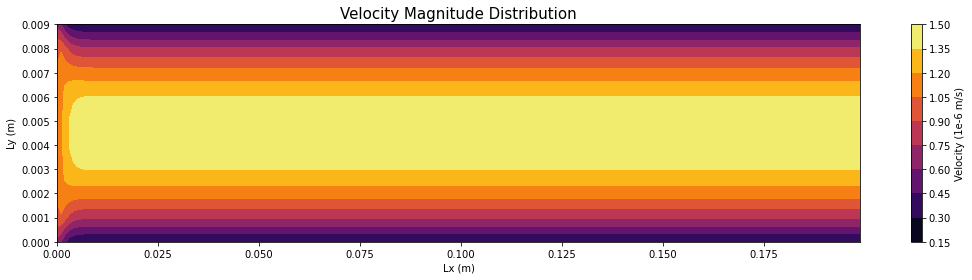

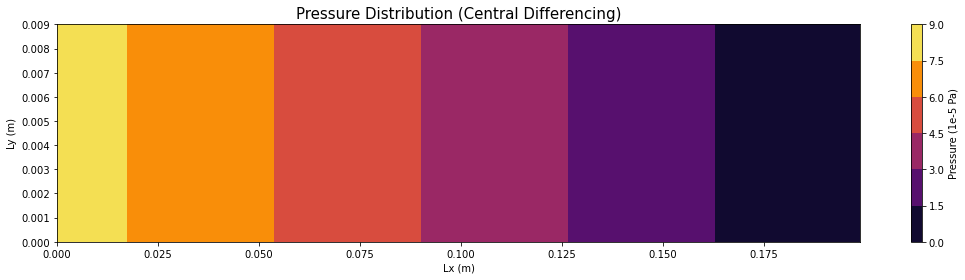

In [44]:
#geometry
Lx = 0.2 #length x direction
Ly = 0.01
#mesh
Nx = 200
Ny =10
dx = Lx/Nx
dy = Ly/Ny
#coordinates
xcoord = np.arange(dx/2,Lx,dx, dtype=float)
xcoord = np.insert(xcoord, 0, 0, axis=None)
xcoord = np.insert(xcoord, len(xcoord), Lx, axis=None)
ycoord = np.arange(dy/2,Ly,dy, dtype=float)
ycoord = np.insert(ycoord, 0, 0, axis=None)
ycoord = np.insert(ycoord, len(ycoord), Ly, axis=None)


#Material properties
mu = 3.5e-3
rho = 1050

#Boundary condition
vin = np.array([0.1,0])

#other parameters
scaleFactor = 1
max_its = 5
tol = 1e-15

v,vmag, p, u, iterations, residualsp,residualsvx, residualsvy,pressure_gradient= CFD(Lx,Ly,Nx,Ny,mu,rho,vin,scaleFactor,max_its,tol)

# Gather Results

In [9]:
dir_name = Path("Master Results")
dir_name.mkdir(parents=True, exist_ok=True)

## Get Freestream Profile from previous simulation

In [22]:
def free_stream_section(vmag, per_cent, Nx, Ny): #per_cent is where to cut the cross section
    
    bot = math.ceil(Nx*per_cent) #middle cell bottom of block
    top = bot+int(Nx*Ny)#middle cell top of block
    cells = np.arange(bot,top,Nx)#cells along middle of block
    vel_free = vmag[cells]
    vel_free = np.insert(vel_free, 0, 0, axis=None)
    vel_free = np.insert(vel_free, len(vel_free), 0, axis=None)
#     plt.plot(vel_free)
    return vel_free

## Analytical vs Numerical Free Stream Velocity Plot

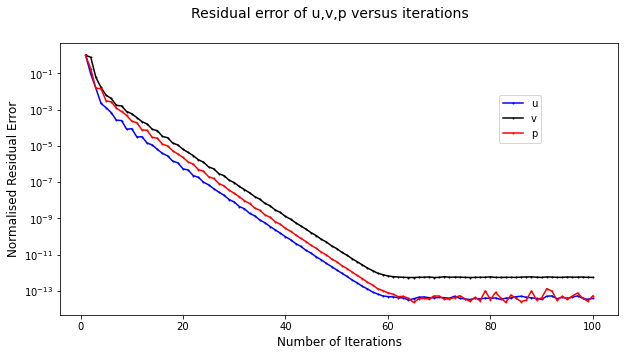

In [33]:
fig, ax1 = plt.subplots(figsize=(10, 5))
iters_array = np.arange(1,iterations+1)

ax1.plot(iters_array,residualsvx, 'b',iters_array,residualsvy, 'k',iters_array,residualsp,'r', marker = 'o',markersize = 1)
fig.legend(['u', 'v','p'],bbox_to_anchor=(0.80, 0.75))
fig.suptitle('Residual error of u,v,p versus iterations', fontsize = 14, weight = 500)
ax1.set_xlabel('Number of Iterations', fontsize = 12, weight = 500)
plt.yscale('log')
ax1.set_ylabel('Normalised Residual Error', fontsize = 12, weight = 500)
plt.savefig(dir_name/'residualsCD.png')

## Pressure across middle of channel

In [26]:
def PmidChannel(p,Nx,Ny):
    
    #start 50% into channel for developed flow
    left = int(Ny/2*Nx)
    cells = np.arange(left,left+Nx)
    pmiddle = p[cells]
    
    return pmiddle
    

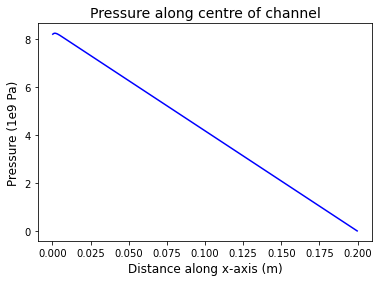

In [27]:
pmiddle = PmidChannel(p,Nx,Ny)
mag = -orderOfMagnitude(pmiddle[0])
plt.figure()
plt.plot(xcoord, pmiddle*1e9, 'b', markersize = 1.5)
plt.title('Pressure along centre of channel', fontsize = 14, weight = 500)
plt.xlabel('Distance along x-axis (m)', fontsize = 12, weight = 500)
plt.ylabel('Pressure (1e9 Pa)', fontsize = 12, weight = 500)
plt.savefig(dir_name/'pmidChannelnosmoothing.png')

## VTK Format

In [10]:


from pathlib import Path
dir_vtk = Path("VTK_results")
dir_vtk.mkdir(parents=True, exist_ok=True)


preamble = '# vtk DataFile Version 2.0\nTube Example\nASCII \n' 
Nz = 1
dx = Lx/Nx
dy = Ly/Ny
ycoord = np.arange(0,Ly+dy,dy, dtype=float)
xcoord = np.arange(0,Lx+dx,dx, dtype=float)
zcoord = np.array([0,1])
fname = 'solidBlock.vtk'
with open(dir_vtk/fname, "w") as f:
        f.write(preamble)
        f.write('DATASET STRUCTURED_GRID DIMENSIONS %i %i %i\n'%(Nx+1,Ny+1,Nz))
        f.write('POINTS %i float\n' %((Nx+1)*(Ny+1)))
        count = 0
            
        for y in ycoord:
            for x in xcoord:
#                 count+=1
                f.write('%f %f 0.0 \n' %(x,y))
                
        f.write('CELL_DATA %i\n'%((Nx)*(Ny)))
        f.write('SCALARS Deformation(m) float 1\nLOOKUP_TABLE default\n')
        for d in disp:
#             print(1e5*vel)
            f.write('%.8f\n'%(d))
    
#         f.write('CELL_DATA %i\n'%((Nx)*(Ny)))
        f.write('SCALARS Pressure(Pa) float 1\nLOOKUP_TABLE default\n')
        for pe in p:
            f.write('%.8f\n'%(pe))
            
#         f.write('VECTORS Velocity(1e11m/s) float\n')
# #         f.write('LOOKUP_TABLE default\n')
#         for i in range(0,len(v)-1,3):
#             f.write('%f %f 0\n'%(1e11*v[i],1e11*v[i+1]))
        
        
            
#        `